### This notebook is for A Wilde's Project 2 of DATA 71200

# A description of the problem:
Testing a dichotomous variable "isWorking" as the label instead of the many different values for employment

## In this notebook:
### Project 1:
#### 1) Loading the Data
##### Defining the Label 
#### 2) Cleaning the Data
#### 3) Applying Log
#### 4) Cleaning - one-hot encoding 
#### 5) Seperate out test set
#### 6) Standard Scaling of Test and Train
#### 7) Seperate out labels
### Project 2:
### 8) Logistic Regression
### 9) Decision Trees

In [2]:
import pandas as pd
import numpy as np

## Project 1
### 1) Load in the binned data

In [3]:
seniors_df = pd.read_csv("2009_binned_2.csv")

#### Getting a Label: 
- Calculate a combo field from EMPSTAT and WKSTAT 
- Transform to numeric

In [4]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
seniors_empwkstat = seniors_df['EMPWKSTAT']
seniors_empwkstat_encoded = encoder.fit_transform(seniors_empwkstat)
seniors_df['EMPWKSTAT_Num']= pd.DataFrame(seniors_empwkstat_encoded)

In [5]:
seniors_df['EMPWKSTAT_Num'].value_counts()

3    15865
0     1756
5     1715
4     1084
2      547
6      225
1      210
Name: EMPWKSTAT_Num, dtype: int64

### 2) Data Cleaning
- Calculating New Values
- Dropping correlated values
- Handling Nulls

The following for calculating new values was adapted from the book *Hands-on Machine Learning* Chapter 2

#### Combining Attributes 
- for citizen percent of life **note this uses a hardcoded year value for this data (From 2009)**
- total passive income

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

In [7]:
# Class to combine attributes for Percent of Life one was Citizen and Total Passive Income
# Instantiation 
#   Input: 2 boolean values to add the two columns
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: All Attributes in a DataFrame 
class DF_CombinedAttributesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,add_citizen_percent_of_life = True, add_total_passive_inc = True):
        self.add_citizen_percent_of_life = add_citizen_percent_of_life
        self.add_total_passive_inc = add_total_passive_inc
    def fit(self, X, y = None):
        return self # nothing to do on fit
    def transform(self, X_df, y = None):
        #X is a data frame
        X_df_copy = X_df.copy(deep=True)
        if self.add_citizen_percent_of_life:
            X_df_copy['percent_of_life']=X_df_copy.apply(lambda row: (2009-int(row['YRIMMIG'][0:4]))/int(row['AGE']) if not pd.isna(row['YRIMMIG']) else 1,axis = 1)
        if self.add_total_passive_inc:
            X_df_copy['passive_inc'] = X_df_copy.apply(lambda row: row['INCTOT']-row['all_wages']-row['all_business_farm'],axis = 1)
        return X_df_copy

In [11]:
#test it
#adder = DF_CombinedAttributesTransformer()
#strat_seniors_train_combined_attribs = adder.transform(strat_seniors_train)
#strat_seniors_train_combined_attribs['percent_of_life'].value_counts()

#### Transformer for Dropping The Unnecssary Columns
This is also adapted from *Hands-on Machine Learning* Chapter 2

### 3) Applying logorithmic transform

because this is useful

Other transforms below, but not used

In [8]:
log_column_list=['INCDIVID','INCRETIR']

In [9]:
# Class to apply logorithmic scaling to a given list of columns
# Instantiation 
#   Input: a list of columns to scale logorithmically
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: All Attributes in a DataFrame with the null values replaced
class DF_GetLogValuesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_log):
        self.columns_to_log = columns_to_log
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X_df, y=None):
        #X is a Data Frame
        X_df_copy = X_df.copy(deep=True)
        for column in self.columns_to_log:
            X_df_copy[column]=X_df_copy[column].apply(lambda x: np.log(x+1))
        return X_df_copy

In [10]:
get_logs = DF_GetLogValuesTransformer(log_column_list)
seniors_df_cleaned_log = get_logs.fit_transform(seniors_df)
seniors_df_cleaned_log.shape

(21402, 60)

### 4) Cleaning of Data:

#### Attribute One-hot (best done before splitting test) 
Adapted from *Hands-on Machine Learning* Chapter 2

In [21]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [22]:
# define columns for numeric vs categorical pipelines
numeric_columns = ['HOUSRET','AGE','INCSS','INCWELFR','INCRETIR','INCSSI','INCDIVID','INCALIM',
                   'all_disability','all_survivor','percent_of_life','passive_inc']
categor_columns = ['OWNERSHP','PUBHOUS','RENTSUB','SEX','RACE','MARST','CITIZEN','HISPAN','EDUC','SRCRETI1',
                  'GOTVDISA','GOTVOTHE','GOTVPENS','GOTVSURV','SRCRETI2',"passive_inc_binned", "EDUC_bin", "MARST_bin"]
passthrough_numeric = ['EMPWKSTAT_Num']
passthrough_categor = ['EMPWKSTAT']

In [23]:
# Helper transformer to seperate out the given columns of a DataFrame
# Instantiation 
#   Input: a list of the columns to select
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: NP Array with just the selected columns
class DF_NP_Column_Selector(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_select):
        self.columns_to_select = columns_to_select
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X_df, y=None):
        #X is a Data Frame
        return X_df[self.columns_to_select].to_numpy()
    def get_feature_names(self):
        return self.columns_to_select

In [24]:
from sklearn.pipeline import Pipeline
categor_pipeline= Pipeline([
    ('selector', DF_NP_Column_Selector(categor_columns)),
    ('1hot_encoder', OneHotEncoder())
])

#### One hot encode the categorical values

In [35]:
categor_cols = categor_pipeline.fit_transform(seniors_df_cleaned_log)
categor_cols.shape

(21402, 101)

In [36]:
categor_names = categor_pipeline['1hot_encoder'].get_feature_names()
len(categor_names)

101

#### Re-join to orginal data

In [37]:
seniors_to_join= seniors_df_cleaned_log.drop(columns=categor_columns)
curr_columns = seniors_to_join.columns
np_seniors_to_join=seniors_to_join.to_numpy()

In [38]:
categor_cols=categor_cols.toarray()

In [39]:
seniors_np_categor_processed = np.column_stack((np_seniors_to_join,categor_cols))

In [40]:
seniors_df_categor_processed = pd.DataFrame(seniors_np_categor_processed, columns = [*curr_columns,*categor_names])

In [41]:
seniors_df_categor_processed.columns.values

array(['HOUSRET', 'CPSIDP', 'AGE', 'YRIMMIG', 'EMPSTAT', 'OCC', 'IND',
       'CLASSWKR', 'UHRSWORKT', 'WKSTAT', 'WKSWORK1', 'WHYPTLY',
       'FTOTVAL', 'INCTOT', 'INCWAGE', 'INCSS', 'INCWELFR', 'INCRETIR',
       'INCSSI', 'INCDIVID', 'INCRENT', 'INCALIM', 'INCOTHER', 'INCLONGJ',
       'SRCEARN', 'TAXINC', 'HOURWAGE', 'UNION', 'ratio_tax_income',
       'multi_jobs', 'all_business_farm', 'all_disability',
       'all_survivor', 'reported_inc_diff', 'EMPWKSTAT', 'isWorking',
       'isRetired', 'EMPWKSTAT_Num', 'percent_of_life', 'passive_inc',
       'spouse_present', 'INCWAGE_sel', 'x0_No cash rent',
       'x0_Owned or being bought', 'x0_With cash rent', 'x1_NIU', 'x1_No',
       'x1_Yes', 'x2_0', 'x2_No', 'x2_Yes', 'x3_Female', 'x3_Male',
       'x4_American Indian/Aleut/Eskimo', 'x4_Asian only',
       'x4_Asian-Hawaiian/Pacific Islander', 'x4_Black-American Indian',
       'x4_Black/Negro', 'x4_Hawaiian/Pacific Islander only', 'x4_White',
       'x4_White-American Indian', 'x4_

#### Seperate out test and train before standard scaling

### 5) Seperate out a test set
(stratified by dichotomous employment status)

Adapted from Hands On Machine Learning book

In [42]:
seniors_df_categor_processed['isWorking']=seniors_df_categor_processed['isWorking'].apply(lambda x: "Working" if x == True  else "Not Working")

In [43]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=17)
for train_index, test_index in split.split(seniors_df_categor_processed, seniors_df_categor_processed['isWorking']):
    strat_seniors_train = seniors_df_categor_processed.loc[train_index]
    strat_seniors_test = seniors_df_categor_processed.loc[test_index]

In [44]:
strat_seniors_train['isWorking'].value_counts() /len(strat_seniors_train)

Not Working    0.827986
Working        0.172014
Name: isWorking, dtype: float64

In [45]:
strat_seniors_test['isWorking'].value_counts() /len(strat_seniors_test)

Not Working    0.82807
Working        0.17193
Name: isWorking, dtype: float64

In [46]:
strat_seniors_train.shape

(16051, 143)

In [47]:
strat_seniors_test.shape

(5351, 143)

### 6) Standard Scaling

In [48]:
from sklearn.impute import SimpleImputer
numeric_pipeline = Pipeline([
    ('selector', DF_NP_Column_Selector(numeric_columns)),
    ('std_scaler', StandardScaler()),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0))
])

In [49]:
train_numeric_cols = numeric_pipeline.fit_transform(strat_seniors_train)
train_numeric_cols.shape

(16051, 12)

In [50]:
test_numeric_cols = numeric_pipeline.fit_transform(strat_seniors_test)
test_numeric_cols.shape

(5351, 12)

##### Rejoin to the original data
- for Train
- for Test

In [51]:
strat_seniors_train_to_join= strat_seniors_train.drop(columns=numeric_columns)
curr_columns = strat_seniors_train_to_join.columns
np_strat_seniors_train_to_join=strat_seniors_train_to_join.to_numpy()

In [52]:
strat_seniors_train_prepared = np.column_stack((np_strat_seniors_train_to_join,train_numeric_cols))

In [53]:
seniors_df_train = pd.DataFrame(strat_seniors_train_prepared, columns = [*curr_columns,*numeric_columns])

In [54]:
strat_seniors_test_to_join= strat_seniors_test.drop(columns=numeric_columns)
curr_columns = strat_seniors_test_to_join.columns
np_strat_seniors_test_to_join=strat_seniors_test_to_join.to_numpy()

In [55]:
strat_seniors_test_prepared = np.column_stack((np_strat_seniors_test_to_join,test_numeric_cols))

In [56]:
seniors_df_test = pd.DataFrame(strat_seniors_test_prepared, columns = [*curr_columns,*numeric_columns], )

##### Drop the label Num value used in earlier visualizations and 

In [57]:
seniors_df_train=seniors_df_train.drop(columns=['EMPWKSTAT_Num','INCWAGE_sel','EMPSTAT','WKSTAT','all_business_farm',"INCWAGE","multi_jobs","isRetired",
                                                'INCLONGJ','WKSWORK1','WHYPTLY','TAXINC','HOURWAGE','UNION', 'FTOTVAL','INCTOT','INCOTHER',
                                               'reported_inc_diff','CLASSWKR','UHRSWORKT','SRCEARN','ratio_tax_income','multi_jobs',
                                               'YRIMMIG','OCC','IND','CPSIDP','EMPWKSTAT'])
seniors_df_test=seniors_df_test.drop(columns=['EMPWKSTAT_Num','INCWAGE_sel','EMPSTAT','WKSTAT','all_business_farm',"INCWAGE","multi_jobs","isRetired",
                                                'INCLONGJ','WKSWORK1','WHYPTLY','TAXINC','HOURWAGE','UNION', 'FTOTVAL','INCTOT','INCOTHER',
                                               'reported_inc_diff','CLASSWKR','UHRSWORKT','SRCEARN','ratio_tax_income','multi_jobs',
                                               'YRIMMIG','OCC','IND','CPSIDP','EMPWKSTAT'])

### 7) Seperate the labels 

In [58]:
# Seperate out the labels
# Instantiation 
#   Input: the label column
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: Dataframe without the labels, NP array of the labels
class DF_NP_Cat_Label_Seperator(BaseEstimator, TransformerMixin):
    def __init__(self, label_column):
        self.label_column = label_column
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X_df, y=None):
        #X is a Data Frame
        labels_np = X_df[self.label_column].to_numpy()
        X_df_no_labels = X_df.drop(columns=self.label_column)
        return X_df_no_labels, labels_np

In [59]:
label_seperator = DF_NP_Cat_Label_Seperator('isWorking')
seniors_df_train_nol, train_labels = label_seperator.transform(seniors_df_train)
seniors_df_test_nol, test_labels = label_seperator.transform(seniors_df_test) 

In [60]:
seniors_np_train_nol = seniors_df_train_nol.to_numpy()

In [61]:
seniors_np_test_nol = seniors_df_test_nol.to_numpy()

## Project 2:

## 8) Try a simple model - Logistic Regression
- run with default settings
- run CV to determine best setting

#### Default

In [62]:
from sklearn.linear_model import LogisticRegression

In [63]:
logreg= LogisticRegression()

In [64]:
logreg.fit(seniors_np_train_nol, train_labels)
print("Training set score: {:.2f}".format(logreg.score(seniors_np_train_nol, train_labels)))
print("Test set score: {:.2f}".format(logreg.score(seniors_np_test_nol, test_labels)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training set score: 0.85
Test set score: 0.85


In [90]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, logreg.predict(seniors_np_test_nol)))

              precision    recall  f1-score   support

 Not Working       0.86      0.97      0.91      4431
     Working       0.64      0.25      0.36       920

    accuracy                           0.85      5351
   macro avg       0.75      0.61      0.64      5351
weighted avg       0.82      0.85      0.82      5351



#### GridSearch + CV to find the best hyper parameters

In [65]:
from sklearn.model_selection import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=17)

In [66]:
from sklearn.model_selection import GridSearchCV
C_range = [.001,.01, .1, 1, 10, 100]
param_grid = dict(C=C_range)

# polynomial kernel
grid_logreg = GridSearchCV(LogisticRegression(solver='liblinear',multi_class='auto'), param_grid=param_grid, cv=cv)
grid_logreg.fit(seniors_np_train_nol, train_labels)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=17, test_size=0.2,
            train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [67]:
print("The best parameters are %s with a score of %0.2f"
      % (grid_logreg.best_params_, grid_logreg.best_score_))

The best parameters are {'C': 10} with a score of 0.84


In [68]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, grid_logreg.best_estimator_.predict(seniors_np_test_nol)))

              precision    recall  f1-score   support

 Not Working       0.86      0.97      0.91      4431
     Working       0.64      0.25      0.36       920

    accuracy                           0.85      5351
   macro avg       0.75      0.61      0.64      5351
weighted avg       0.82      0.85      0.82      5351



## 9) Try some complex models:
- Naive Bayes, 
- Decision Trees incl. Random Forrest, and Gradient Boosting Decision Trees

#### Naive Bayes Gaussian model

In [69]:
from sklearn.naive_bayes import GaussianNB

In [70]:
gNB_bad = GaussianNB()
gNB_bad.fit(seniors_np_train_nol, train_labels)

GaussianNB(priors=None, var_smoothing=1e-09)

In [71]:
print("Training set score: {:.2f}".format(gNB_bad.score(seniors_np_train_nol, train_labels)))
print("Test set score: {:.2f}".format(gNB_bad.score(seniors_np_test_nol, test_labels)))

Training set score: 0.67
Test set score: 0.66


In [72]:
gNB_bad.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [73]:
from sklearn.model_selection import GridSearchCV
var_smoothing_range = [.0001,.001, .01, 1, 10, 100]
param_grid = dict(var_smoothing=var_smoothing_range)

# polynomial kernel
grid_gNB = GridSearchCV(GaussianNB(), param_grid=param_grid, cv=cv)
grid_gNB.fit(seniors_np_train_nol, train_labels)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=17, test_size=0.2,
            train_size=None),
             error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn',
             n_jobs=None,
             param_grid={'var_smoothing': [0.0001, 0.001, 0.01, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [74]:
print("The best parameters are %s with a score of %0.2f"
      % (grid_gNB.best_params_, grid_gNB.best_score_))

The best parameters are {'var_smoothing': 10} with a score of 0.83


In [75]:
print(classification_report(test_labels, grid_gNB.best_estimator_.predict(seniors_np_test_nol)))

              precision    recall  f1-score   support

 Not Working       0.83      1.00      0.91      4431
     Working       0.00      0.00      0.00       920

    accuracy                           0.83      5351
   macro avg       0.41      0.50      0.45      5351
weighted avg       0.69      0.83      0.75      5351



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Helper function to plot feature importance

In [76]:
%matplotlib inline 
import matplotlib.pyplot as plt 

def plot_feature_importances(model, data, feature_names):
    n_features = data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

### Decision Tree 

In [77]:
from sklearn.tree import DecisionTreeClassifier

In [78]:
tree_bad = DecisionTreeClassifier()

In [79]:
tree_bad.fit(seniors_np_train_nol, train_labels)
print("Accuracy on training set: {:.3f}".format(tree_bad.score(seniors_np_train_nol, train_labels)))
print("Accuracy on test set: {:.3f}".format(tree_bad.score(seniors_np_test_nol, test_labels)))

Accuracy on training set: 0.999
Accuracy on test set: 0.763


In [80]:
max_depth_range = [1,2,5,20,50,100]
min_samples_leaf_range = [1,2,5,20,50,100]
param_grid = dict(max_depth=max_depth_range,min_samples_leaf=min_samples_leaf_range)

## DecisionTree
grid_tree = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=cv)
grid_tree.fit(seniors_np_train_nol, train_labels)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=17, test_size=0.2,
            train_size=None),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max

In [81]:
print("The best parameters are %s with a score of %0.2f"
      % (grid_tree.best_params_, grid_tree.best_score_))

The best parameters are {'max_depth': 20, 'min_samples_leaf': 100} with a score of 0.84


In [82]:
print(classification_report(test_labels, grid_tree.best_estimator_.predict(seniors_np_test_nol)))

              precision    recall  f1-score   support

 Not Working       0.86      0.97      0.91      4431
     Working       0.61      0.21      0.31       920

    accuracy                           0.84      5351
   macro avg       0.73      0.59      0.61      5351
weighted avg       0.81      0.84      0.81      5351



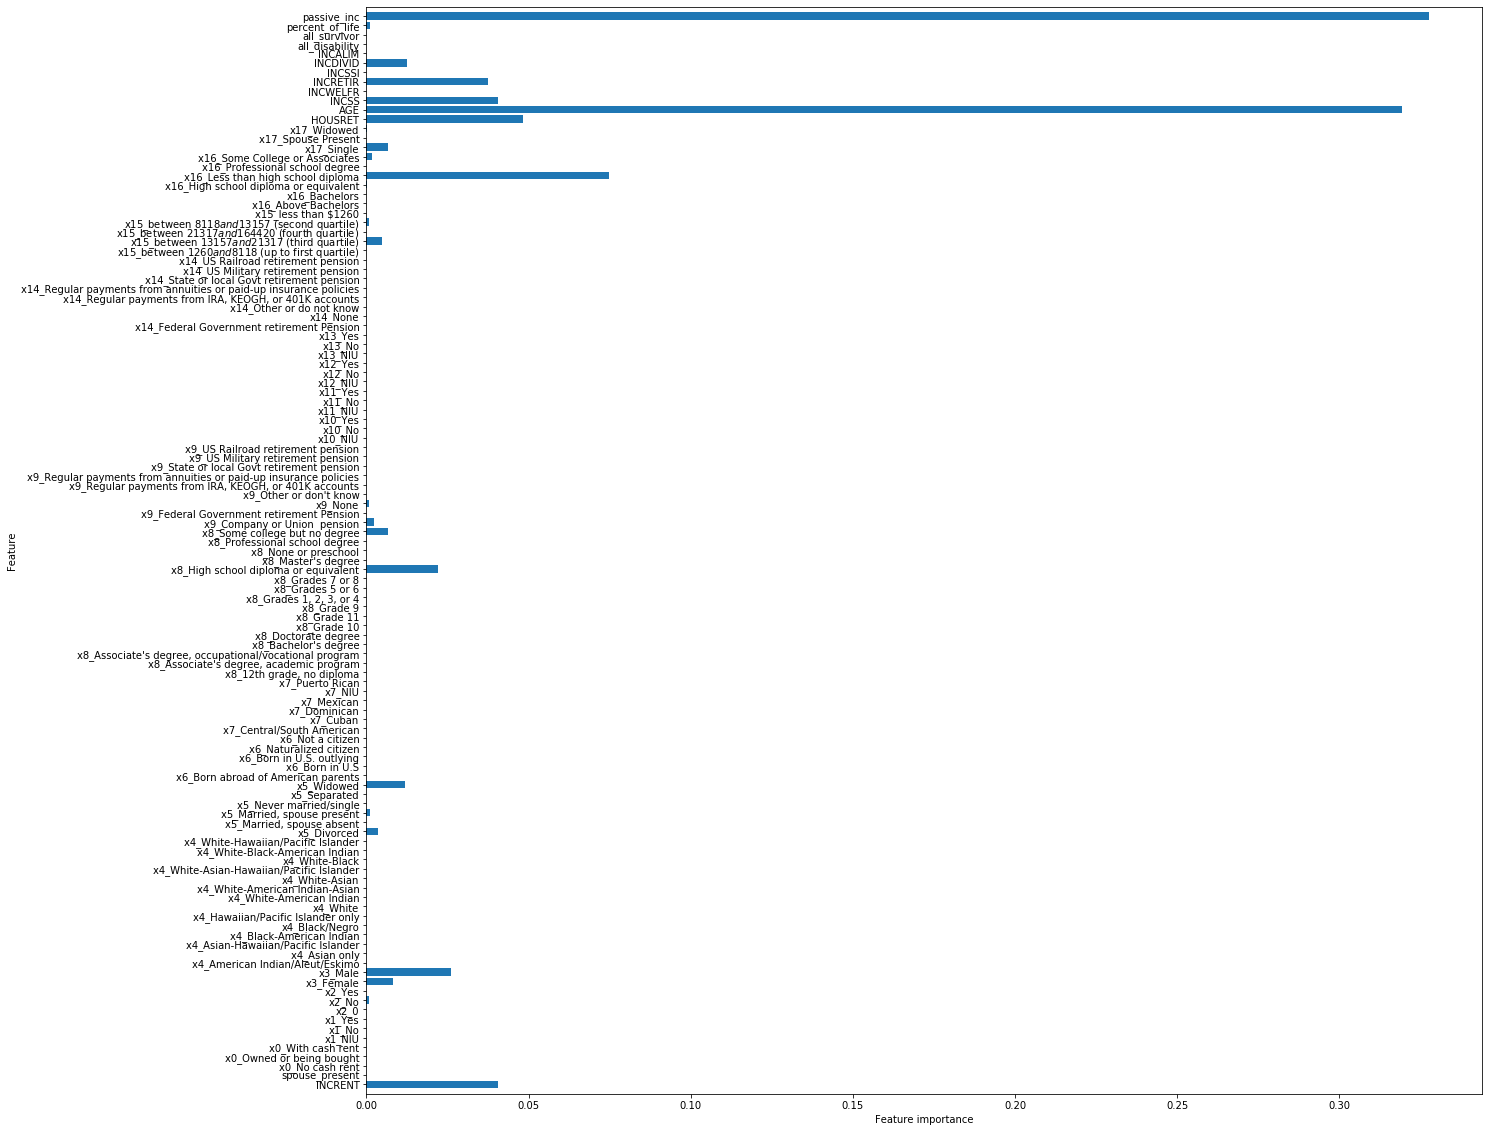

In [83]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
plot_feature_importances(grid_tree.best_estimator_, seniors_np_train_nol, seniors_df_train_nol.columns)

### Random Forest

In [84]:
from sklearn.ensemble import RandomForestClassifier

In [85]:
forest = RandomForestClassifier()
forest.fit(seniors_np_train_nol, train_labels)
print("Accuracy on training set: {:.3f}".format(forest.score(seniors_np_train_nol, train_labels)))
print("Accuracy on test set: {:.3f}".format(forest.score(seniors_np_test_nol, test_labels)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy on training set: 0.980
Accuracy on test set: 0.832


In [86]:
n_estimators_range = [2,5,10,20,50]
max_features_range = [2,5,10,20,50]
min_samples_leaf_range = [1,2,5]
param_grid = dict(n_estimators=n_estimators_range,max_features=max_features_range,
                  min_samples_leaf=min_samples_leaf_range)

# polynomial kernel
grid_forest = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=cv)
grid_forest.fit(seniors_np_train_nol, train_labels)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=17, test_size=0.2,
            train_size=None),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              rand

In [87]:
print("The best parameters are %s with a score of %0.2f"
      % (grid_forest.best_params_, grid_forest.best_score_))

The best parameters are {'max_features': 20, 'min_samples_leaf': 5, 'n_estimators': 50} with a score of 0.84


In [88]:
print(classification_report(test_labels, grid_forest.best_estimator_.predict(seniors_np_test_nol)))

              precision    recall  f1-score   support

 Not Working       0.85      0.99      0.92      4431
     Working       0.76      0.17      0.28       920

    accuracy                           0.85      5351
   macro avg       0.81      0.58      0.60      5351
weighted avg       0.84      0.85      0.81      5351



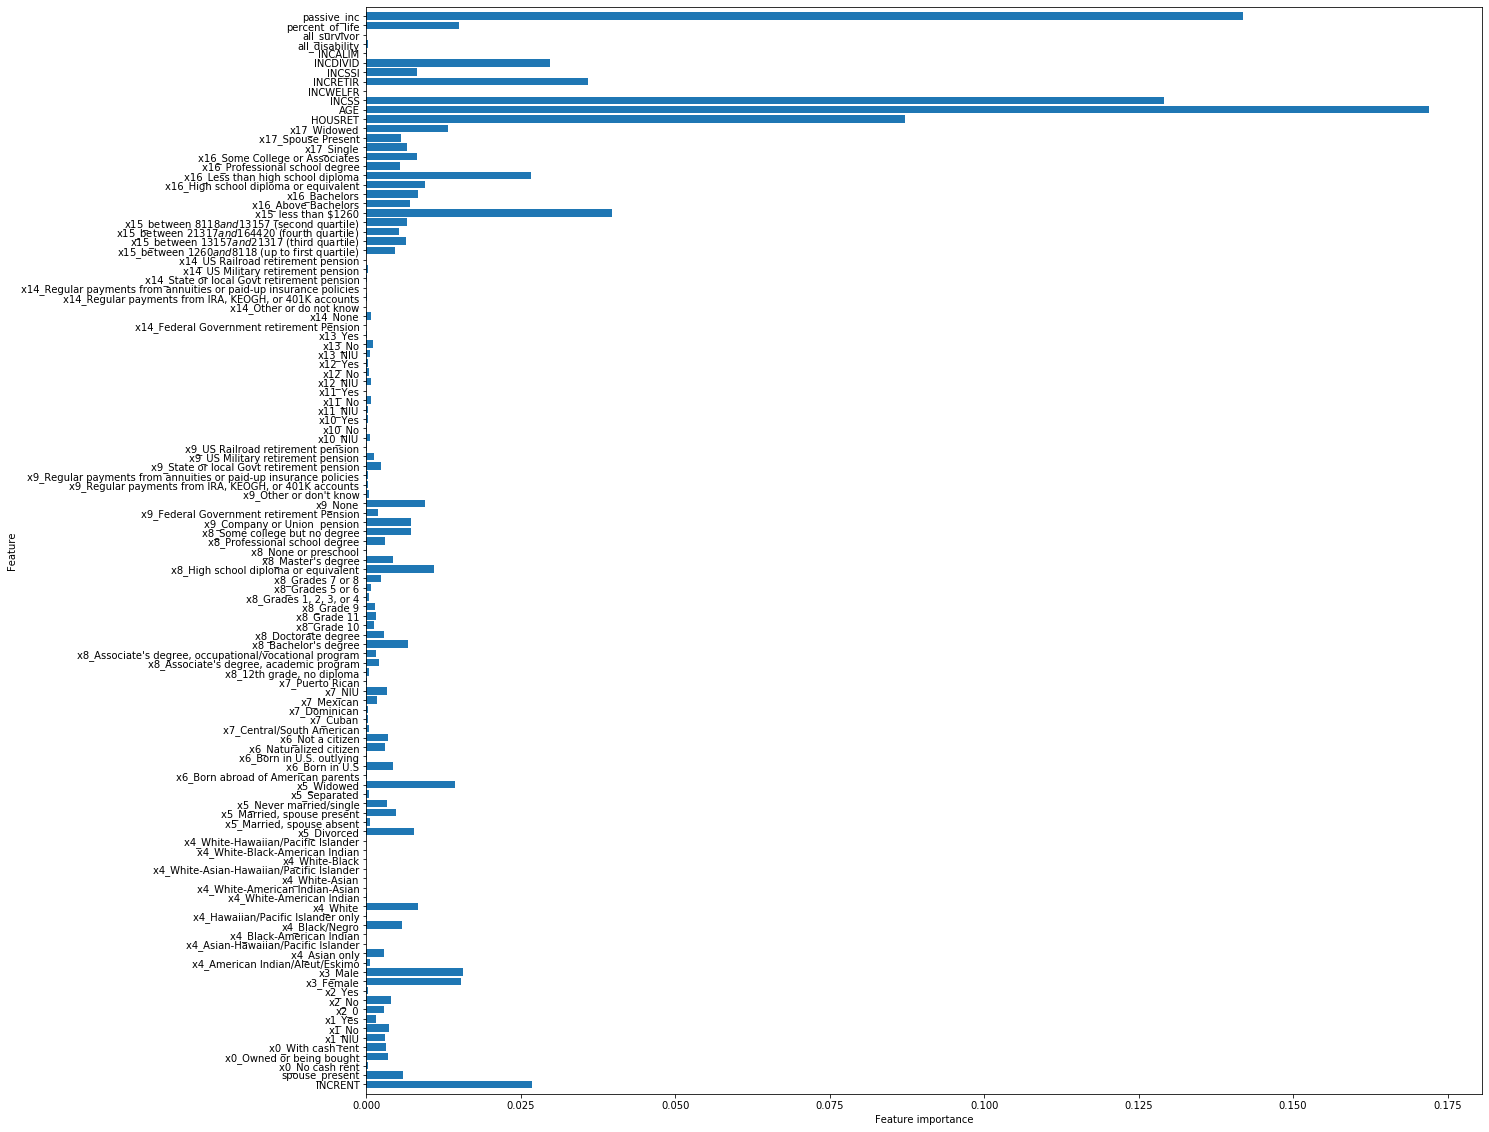

In [89]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
plot_feature_importances(grid_forest.best_estimator_, seniors_np_train_nol, seniors_df_train_nol.columns)

### Gradient Boosting Decision Trees

In [91]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=17)
gbrt.fit(seniors_np_train_nol, train_labels)

print("Accuracy on training set: {:.3f}".format(gbrt.score(seniors_np_train_nol, train_labels)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(seniors_np_test_nol, test_labels)))

Accuracy on training set: 0.856
Accuracy on test set: 0.850


In [92]:
n_estimators_range = [2,5,10,20,30]
max_depth_range = [2,5,10]
param_grid = dict(n_estimators=n_estimators_range,max_depth=max_depth_range)

# polynomial kernel
grid_boostedforest = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid, cv=cv)
grid_boostedforest.fit(seniors_np_train_nol, train_labels)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=17, test_size=0.2,
            train_size=None),
             error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_lea...
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                         

In [93]:
print("The best parameters are %s with a score of %0.2f"
      % (grid_boostedforest.best_params_, grid_boostedforest.best_score_))

The best parameters are {'max_depth': 5, 'n_estimators': 30} with a score of 0.84


In [94]:
print(classification_report(test_labels, grid_boostedforest.best_estimator_.predict(seniors_np_test_nol)))

              precision    recall  f1-score   support

 Not Working       0.85      0.98      0.91      4431
     Working       0.71      0.18      0.29       920

    accuracy                           0.85      5351
   macro avg       0.78      0.58      0.60      5351
weighted avg       0.83      0.85      0.81      5351



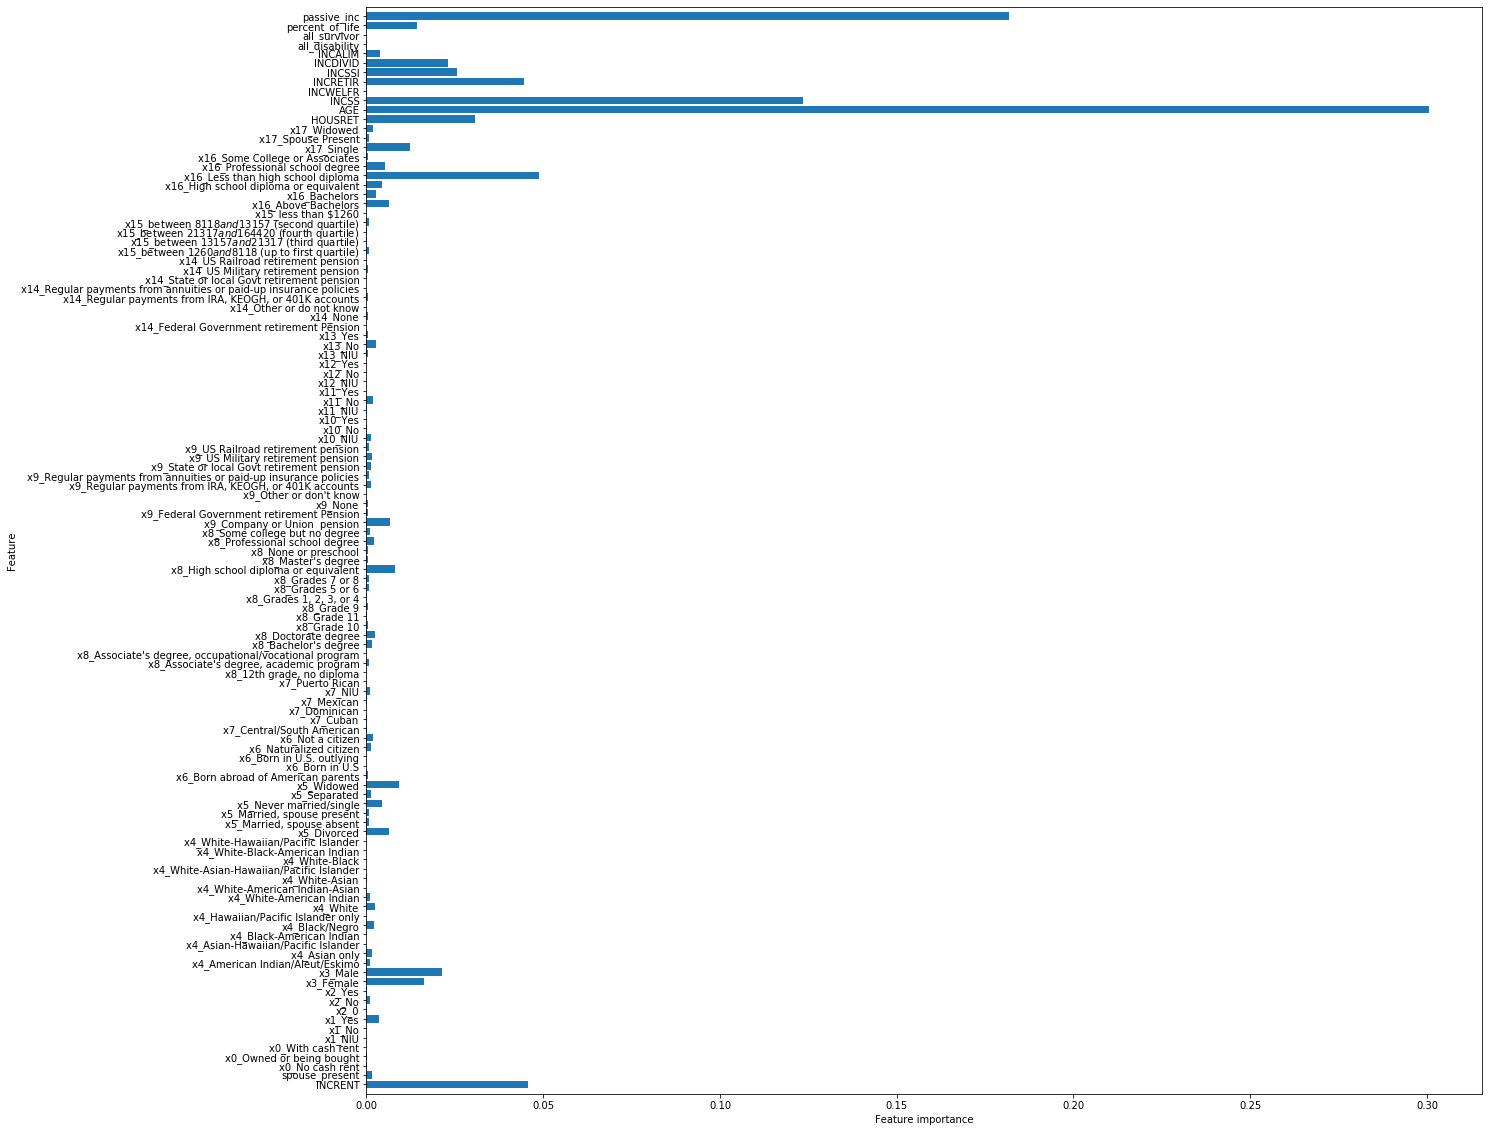

In [95]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
plot_feature_importances(grid_boostedforest.best_estimator_, seniors_np_train_nol, seniors_df_train_nol.columns)